# CS 20 : TensorFlow for Deep Learning Research
## Lecture 5 : Variable sharing and managing experiments
### Applied example with tf.placeholder
Ref : [Toward Best Practices of TensorFlow Code Patterns](https://wookayin.github.io/TensorFlowKR-2017-talk-bestpractice/ko/#1) by Jongwook Choi, Beomjun Shin  
  
- Creating the **input pipeline** with tf.placeholder
- Creating the model as **Class**
- Training the model with **learning rate scheduling** by exponential decay learning rate
- Saving the model and Restoring the model

### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

print(tf.__version__)

/Users/kbs/.virtualenvs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.7.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 784)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 784)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 784) (55000,)
(5000, 784) (5000,)


### Define DNN Classifier with two hidden layer

In [4]:
class DNNClassifier:
    def __init__(self, X, y, n_of_classes, hidden_dims = [100, 50], name = 'DNN'):
        
        with tf.variable_scope(name):
            with tf.variable_scope('input_layer'):
                self._X = X
                self._y = y
        
            h = self._X
        
            for layer, h_dim in enumerate(hidden_dims):
                with tf.variable_scope('hidden_layer_{}'.format(layer + 1)):
                    h = tf.nn.tanh(self._fully_connected(X = h, output_dim = h_dim))
        
            with tf.variable_scope('output_layer'):
                score = self._fully_connected(X = h, output_dim = n_of_classes)
        
            with tf.variable_scope('ce_loss'):
                self.ce_loss = self._loss(score = score, y = self._y)
                
            with tf.variable_scope('prediction'):
                self._prediction = tf.argmax(input = score, axis = 1)
        
    def _fully_connected(self, X, output_dim):
        w = tf.get_variable(name = 'weights',
                            shape = [X.shape[1], output_dim],
                            initializer = tf.random_normal_initializer())
        b = tf.get_variable(name = 'biases',
                            shape = [output_dim],
                            initializer = tf.constant_initializer(0.0))
        return tf.matmul(X, w) + b
    
    def _loss(self, score, y):
        loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = y, logits = score))
        return loss
        
    def predict(self, sess, X):
        feed_predict = {self._X : X}
        return sess.run(fetches = self._prediction, feed_dict = feed_predict)

### Create a model of DNN Classifier

In [5]:
## create placeholders for x_data and y_data
x_data = tf.placeholder(dtype = tf.float32, shape = [None, 784])
y_data = tf.placeholder(dtype = tf.int32, shape = [None])

dnn = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

### Create training op and train model
Applying exponential decay learning rate to train DNN model  
```python
decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

```
Ref : https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay

In [6]:
# hyper-parameter
epochs = 15
batch_size = 64
learning_rate = .005
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

859


In [7]:
## Applying exponential decay learning rate to train dnn model
global_step = tf.Variable(initial_value = 0 , trainable = False)
exp_decayed_lr = tf.train.exponential_decay(learning_rate = learning_rate,
                                            global_step = global_step,
                                            decay_steps = total_step * 5,
                                            decay_rate = .9,
                                            staircase = True)

In [8]:
# create training op
opt = tf.train.AdamOptimizer(learning_rate = exp_decayed_lr)

# equal to 'var_list = None'
training_op = opt.minimize(loss = dnn.ce_loss,
                           var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES),
                           global_step = global_step) 

# create summary op for tensorboard
ce_loss_summ = tf.summary.scalar(name = 'ce_loss', tensor = dnn.ce_loss)

In [9]:
train_writer = tf.summary.FileWriter(logdir = '../graphs/lecture05/applied_example_wp/train',
                                     graph = tf.get_default_graph())
val_writer = tf.summary.FileWriter(logdir = '../graphs/lecture05/applied_example_wp/val',
                                     graph = tf.get_default_graph())
saver = tf.train.Saver()

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    
    for step in range(total_step):
        
        batch_indices = np.random.choice(range(x_tr.shape[0]), size = batch_size, replace = False)
        val_indices = np.random.choice(range(x_val.shape[0]), size = batch_size, replace = False)
        
        batch_xs = x_tr[batch_indices] 
        batch_ys = y_tr[batch_indices]
        val_xs = x_val[val_indices]
        val_ys = y_val[val_indices]
        
        _, tr_loss, tr_loss_summ = sess.run(fetches = [training_op, dnn.ce_loss, ce_loss_summ],
                                   feed_dict = {x_data : batch_xs, y_data : batch_ys})

        val_loss, val_loss_summ = sess.run(fetches = [dnn.ce_loss, ce_loss_summ],
                                           feed_dict = {x_data : val_xs, y_data : val_ys})
        avg_tr_loss += tr_loss / total_step
        avg_val_loss += val_loss / total_step
        
    tr_loss_hist.append(avg_tr_loss)
    val_loss_hist.append(avg_val_loss)
    
    train_writer.add_summary(summary = tr_loss_summ, global_step = (epoch + 1))
    val_writer.add_summary(summary = val_loss_summ, global_step = (epoch + 1))
    
    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.2f}, val_loss : {:.2f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))
        saver.save(sess = sess, save_path = '../graphs/lecture05/applied_example_wp/dnn', global_step = (epoch + 1))

train_writer.close()
val_writer.close()

epoch :   5, tr_loss : 0.26, val_loss : 0.29
epoch :  10, tr_loss : 0.17, val_loss : 0.23
epoch :  15, tr_loss : 0.13, val_loss : 0.20


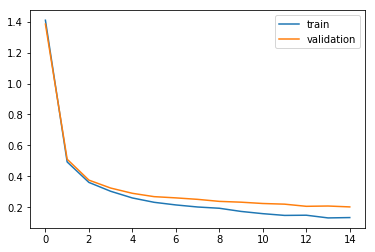

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [12]:
yhat = dnn.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 94.72%


### Restore model

#### Example 1
Restore my model at epoch 15

In [13]:
tf.reset_default_graph()

x_data = tf.placeholder(dtype = tf.float32, shape = [None, 784])
y_data = tf.placeholder(dtype = tf.int32, shape = [None])

dnn_restore = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

In [14]:
ckpt_list = tf.train.get_checkpoint_state(checkpoint_dir = '../graphs/lecture05/applied_example_wp/')
print(ckpt_list) 

model_checkpoint_path: "../graphs/lecture05/applied_example_wp/dnn-15"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-5"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-10"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-15"



In [15]:
# restore my model at epoch 15
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess = sess, save_path = '../graphs/lecture05/applied_example_wp/dnn-15')

INFO:tensorflow:Restoring parameters from ../graphs/lecture05/applied_example_wp/dnn-15


In [16]:
yhat = dnn_restore.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 94.72%


#### Example 2
Restore my model at epoch 10

In [17]:
tf.reset_default_graph()

x_data = tf.placeholder(dtype = tf.float32, shape = [None, 784])
y_data = tf.placeholder(dtype = tf.int32, shape = [None])

dnn_restore = DNNClassifier(X = x_data, y = y_data, n_of_classes = 10)

In [18]:
ckpt_list = tf.train.get_checkpoint_state(checkpoint_dir = '../graphs/lecture05/applied_example_wp/')
print(ckpt_list) 

model_checkpoint_path: "../graphs/lecture05/applied_example_wp/dnn-15"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-5"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-10"
all_model_checkpoint_paths: "../graphs/lecture05/applied_example_wp/dnn-15"



In [19]:
# restore my model at epoch 10
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess = sess, save_path = '../graphs/lecture05/applied_example_wp/dnn-10')

INFO:tensorflow:Restoring parameters from ../graphs/lecture05/applied_example_wp/dnn-10


In [20]:
yhat = dnn_restore.predict(sess = sess, X = x_tst)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))
sess.close()

test acc: 94.23%
